<a href="https://colab.research.google.com/github/vsermoud/Introduction-to-Classical-DFT/blob/main/Implementing_a_dispersive_Functional_Mean_Field_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dispersive contribution - Mean-field approach

### The term of dispersive contributions will represent the attractions that the fluid molecules have with each other. Considering the mean-field approximation, the residual dispersive free energy term ($F_{disp}$) is described as a functional of the density of the fluid by,

### $F_{disp}[\rho(\textbf{r})] = \frac{1}{2}\int \int \rho(\textbf{r})\rho(\textbf{r'})\phi_{disp}(\left|\textbf{r}-\textbf{r'} \right|)\text{d}\textbf{r}\text{d}\textbf{r'}$

### $F_{disp}[\rho(\textbf{r})] = \frac{1}{2}\int \int \rho(\textbf{r})\rho(\textbf{r'})\phi_{disp}(\left|\textbf{r}-\textbf{r'} \right|)\text{d}\textbf{r}\text{d}\textbf{r'}$

### $$
\phi_{\text{disp}}^{\text{WCA}}(r) = \begin{cases}
0 & \text{if } r > 5\sigma \\
4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-2\left(\frac{\sigma}{r}\right)^{6}\right] & \text{if } 2^{\frac{1}{6}}\sigma \leq r \leq 5\sigma \\
-\epsilon & \text{if } r < 2^{\frac{1}{6}}\sigma
\end{cases}
$$

### In which $\sigma$ and $\epsilon$ are the Lennard-Jones parameters.
### Considering the case of the uniform fluid, this description is consistent with the following additive contribution to the equation of state:

### $\mu_{disp} = \rho_b \int \phi_{disp}(\textbf{r}) \text{d}\textbf{r}$

### $P_{disp} = \frac{1}{2} \rho_b^2 \int \phi_{disp}(\textbf{r}) \text{d}\textbf{r} $

### In which $\rho_b$ is the bulk fluid density, and considering the WCA potential:

### $\int \phi_{disp}(\textbf{r}) \text{d}\textbf{r} = -\sqrt{2}\frac{32}{9}\pi \epsilon \sigma^3 + \frac{16}{3}\pi \epsilon \sigma \left[ \left(\frac{\sigma}{r_c} \right)^3-\frac{1}{3} \left(\frac{\sigma}{r_c} \right)^9 \right]$

### In which rc is the cuttof radius. Here we considered rc = 5 $\sigma$.

### To obtain the volumetric properties of a fluid with its parameters and T and P described below.

In [ ]:
#Temperature of the system [K]
T = 80.
#Volumar Pressure [Bar]
P = 1.
#LJ Properties of the molecule probe
Sigma_ff = 3.305 #A
d_HS = 3.38#Sigma_ff
Eps_kb = 118.05 #K
#Boltzmann constant
kb = 1.3806488e-23

### Solid-Fluid parameters

In [ ]:
E_eff = 1000    #Efective wall parameter [K]
Sigma_sf = 2.8 #Solid molecule parameter [Angstrom]

### Removing the dimension of the variables

In [ ]:
# T[K] / Eps_kb[K]
T = T/Eps_kb

# bar -> Pa (kg/m s^2)
# kb [kg⋅m2⋅s−2/K] * Eps_kb[K] * Sigma_ff*1.e-10)**3 [m^3] ~ [kg/m s^2]
P = ((P*1.e5)/(kb*Eps_kb)*(Sigma_ff*1.e-10)**3)

# E_eff[K/A^2] / Eps_kb[K] * Sigma_ff^2 [A^2]
E_eff = 17.61#E_eff/Eps_kb

# Eps_kb[K]
Eps_kb = Eps_kb/Eps_kb

#d_HS[A] / Sigma_ff[A]
d_HS = d_HS/Sigma_ff

#Sigma_sf[A]/Sigma_ff[A]
Sigma_sf = Sigma_sf/Sigma_ff

#Sigma_ff[A]
Sigma_ff = Sigma_ff/Sigma_ff

#R_cut of the WCA potential
rc_MF = 5.*Sigma_ff

### We obtain the mean bulk density of the fluid.

In [ ]:
#%%
#Calculating Rho_H
from scipy.optimize import minimize

def Fobj_Rho(rho0):
    #Initial guess
    Eta = np.pi*rho0*Sigma_ff**3/6.
    #Carnahan–Starling equation of state
    P_cs = T*rho0*(1+Eta+Eta**2-Eta**3)/(1-Eta)**3
    #Mean-Field
    P_MF_WCA = rho0**2*0.5*(-np.sqrt(2)*(32./9.)*np.pi*Eps_kb*Sigma_ff**3 +
              (16./3.)*np.pi*Eps_kb*Sigma_ff**3*((Sigma_ff/(rc_MF))**3 -
              (1./3.)*(Sigma_ff/(5.*rc_MF))**9))
    P_c = P_cs+P_MF_WCA
    return (P_c-P)**2

min_val = minimize(Fobj_Rho, 1.e-7, method='BFGS')

rho_H = min_val.x

### And we calculate the chemical pontential

In [ ]:
#%%
#Chemical-Potential calculation

#Ideal-Gas contribution
mu_ID = T*np.log(rho_H)


#Hard-Sphere Contribution
EtaH = np.pi*rho_H*Sigma_ff**3/6.0
mu_HS = T*(EtaH*(8.0-9.0*EtaH+3.*EtaH**2)/(1.-EtaH)**3)


#Dispersive contribution
mu_MF_WCA = rho_H*(-np.sqrt(2)*(32./9.)*np.pi*Eps_kb*Sigma_ff**3 +
          (16./3.)*np.pi*Eps_kb*Sigma_ff**3*((Sigma_ff/(5.*Sigma_ff))**3 -
          (1./3.)*(Sigma_ff/(5.*Sigma_ff))**9))

#Total Amount
mu_H = mu_ID+mu_HS+mu_MF_WCA

### To transform the interaction potential between two fluid plates, consider the problem described below in cylindrical coordinates, where r represents the distance between a position on the fluid plate on the right located at z = z, and a point on another fluid plate located at z=z'.

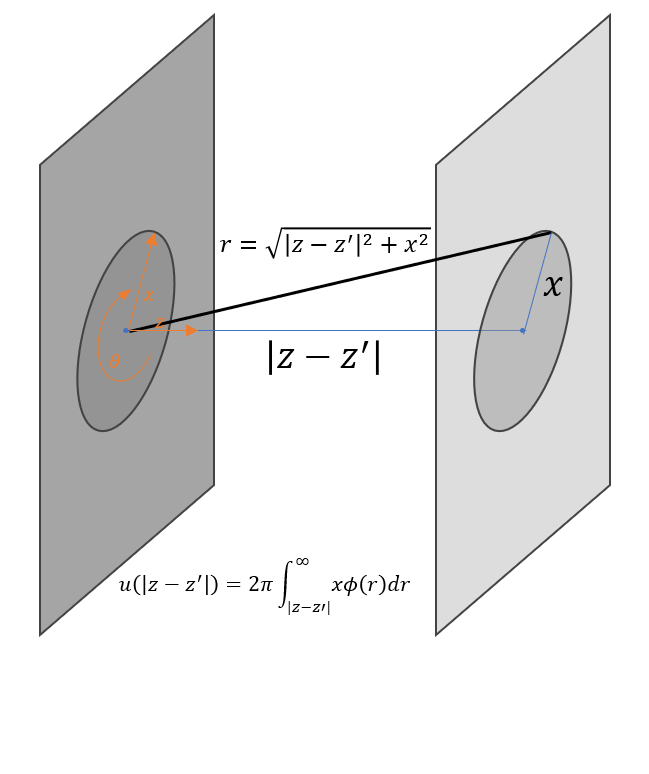

### This allows us to describe the potential ($u(|z-z'|)$) due to a single plane at a distance $|z-z'|$ as:

### $u(|z-z'|) = 2 \pi \int_{|z-z'|}^\infty x \phi(\text{r}) \text{d}\textbf{r}$

### knowing that,

### $r = \sqrt{|z-z'|^2+x^2}$
### $\text{d}(r) = \text{d}(\sqrt{|z-z'|^2+x^2})$

### $\text{d}r = \frac{x}{\sqrt{|z-z'|^2+x^2}}\text{d}x$

### $\text{d}r = \frac{x}{r}\text{d}x$

### $r\text{d}r = x\text{d}x$

### Thus

### $u(|z-z'|) = 2 \pi \int_{|z-z'|}^\infty r \phi(r) \text{d}r$

### This strategy, if used for a Lennard-Jones potential, allows the 10-4 planar wall potential to be found.

### For the WCA potential we should consider when the distance between the planes ($|z-z'|$) is less than $r_{min}$:

### $u(|z-z'|) =  2 \pi \int_{|z-z'|}^\infty r \phi(r) \text{d}r $

### $=  2 \pi \int_{|z-z'|}^{r_{min}} r \phi(r) \text{d}r + 2 \pi \int_{r_{min}}^{r_c} r \phi(r) \text{d}r+0$

### $=  2 \pi \int_{|z-z'|}^{r_{min}}  -\epsilon r \text{d}r + 2 \pi \int_{r_{min}}^{r_c} r\left[\left(\frac{\sigma}{r}\right)^{12}-2\left(\frac{\sigma}{r}\right)^{6}\right] \text{d}r$

### $=  \epsilon \pi \left((|z-z'|^2 - r_{min})^2  \right) + 2 \pi \epsilon \sigma^2 \left[\frac{2}{5}\left(\left(\frac{\sigma}{r_{min}} \right)^{10}-\left(\frac{\sigma}{r_c} \right)^{10} \right)+\left(\left(\frac{\sigma}{r_{c}} \right)^4-\left(\frac{\sigma}{r_{min}} \right)^{4} \right) \right]$

### If the distance between the two planes is greater than $r_{min}$ and less than the cutting radius ($r_c$):

### $u(|z-z'|) = 2 \pi \int_{|z-z'|}^{r_c} r \phi(r) \text{d}r+0$

### $=  2 \pi \int_{|z-z'|}^{r_c} r\left[\left(\frac{\sigma}{r}\right)^{12}-2\left(\frac{\sigma}{r}\right)^{6}\right] \text{d}r$

### $= 2 \pi \epsilon \sigma^2 \left[\frac{2}{5}\left(\left(\frac{\sigma}{|z-z'|} \right)^{10}-\left(\frac{\sigma}{r_c} \right)^{10} \right)+\left(\left(\frac{\sigma}{r_{c}} \right)^4-\left(\frac{\sigma}{|z-z'|} \right)^{4} \right) \right]$

### So for a one-dimensional problem the WCA potential can be rewritten in the form:

### $$
\phi_{\text{disp}}^{\text{WCA}}(|z-z'|) = \begin{cases}
0 & \text{if } r > 5\sigma \\
2 \pi \epsilon \sigma^2 \left[\frac{2}{5}\left(\left(\frac{\sigma}{|z-z'|} \right)^{10}-\left(\frac{\sigma}{r_c} \right)^{10} \right)+\left(\left(\frac{\sigma}{r_{c}} \right)^4-\left(\frac{\sigma}{|z-z'|} \right)^{4} \right) \right] & \text{if } r_{rmin} \leq |z-z'| \leq r_c \\
\epsilon \pi \left((|z-z'|^2 - r_{min})^2  \right) + 2 \pi \epsilon \sigma^2 \left[\frac{2}{5}\left(\left(\frac{\sigma}{r_{min}} \right)^{10}-\left(\frac{\sigma}{r_c} \right)^{10} \right)+\left(\left(\frac{\sigma}{r_{c}} \right)^4-\left(\frac{\sigma}{r_{min}} \right)^{4} \right) \right] & \text{if } |z-z'| < r_{min}
\end{cases}
$$

### Where for WCA potential $r_{min} = 2^\frac{1}{6}\sigma$ and $r_c = 5\sigma$

### Below is a python function algorithm for calculating this potential, where dist represents $|z-z'|$, rc is $r_c$, eps and Sig_ff are the Lennard-Jones parameters of the fluid $\epsilon$ and $\sigma_{ff}$

In [ ]:
import numpy as np
from numba import jit

@jit(nopython=True)
def Phi_wca(dist,rc,eps,Sig_ff):
    rmin = 2.**(1./6.)*Sig_ff
    if dist>rc:
        return 0
    elif (dist>rmin and dist<=rc):
        Temp1 = (2./5.)*(eps*Sig_ff**12)/(dist**10)-eps*Sig_ff**6/(dist**4)
        Temp2 = (2./5.)*(eps*Sig_ff**12)/(rc**10)-eps*Sig_ff**6/(rc**4)
        return  2.*np.pi*(Temp1 - Temp2)
    else:
        Temp0 = 0.5*eps*(dist**2-rmin**2)
        Temp1 = (2./5.)*(eps*Sig_ff**12)/(rmin**10)-eps*Sig_ff**6/(rmin**4)
        Temp2 = (2./5.)*(eps*Sig_ff**12)/(rc**10)-eps*Sig_ff**6/(rc**4)
        return 2.*np.pi*(Temp0 + Temp1 - Temp2)

### Knowing how to calculate the WCA potential, it is necessary to solve the dispersive contribution of the functional derivative of the free energy in relation to the particle density:

### $\frac{\delta F_{MF}[\rho(\textbf{r})]}{\delta\rho(\textbf{r})}=\frac{\delta}{\delta\rho(\textbf{r})}\frac{1}{2}\int \int \rho(\textbf{r'})\rho(\textbf{r''})\phi(|\textbf{r'}-\textbf{r''}|)\text{d}\textbf{r'}\text{d}\textbf{r''}$

### $\frac{\delta F_{MF}[\rho(\textbf{r})]}{\delta\rho(\textbf{r})}=\frac{1}{2} \int \int \frac{\delta\rho(\textbf{r'})}{\delta\rho(\textbf{r})}\rho(\textbf{r''})\phi(|\textbf{r'}-\textbf{r''}|)\text{d}\textbf{r'}\text{d}\textbf{r''}+\frac{1}{2} \int \int \rho(\textbf{r''})\frac{\delta\rho(\textbf{r'})}{\delta\rho(\textbf{r})}\phi(|\textbf{r'}-\textbf{r''}|)\text{d}\textbf{r'}\text{d}\textbf{r''}$

### $\frac{\delta F_{MF}[\rho(\textbf{r})]}{\delta\rho(\textbf{r})}=\frac{1}{2} \int \int \delta(\textbf{r'}-\textbf{r})\rho(\textbf{r''})\phi(|\textbf{r'}-\textbf{r''}|)\text{d}\textbf{r'}\text{d}\textbf{r''}+\frac{1}{2} \int \int \delta(\textbf{r''}-\textbf{r}) \rho(\textbf{r'})\phi(|\textbf{r'}-\textbf{r''}|)\text{d}\textbf{r'}\text{d}\textbf{r''}$

### $\frac{\delta F_{MF}[\rho(\textbf{r})]}{\delta\rho(\textbf{r})}=\frac{1}{2} \int \rho(r'')\phi(|\textbf{r}-\textbf{r''}|)\text{d}\textbf{r''}+\frac{1}{2}\int \rho(\textbf{r'})\phi(|\textbf{r'}-\textbf{r}|)\text{d}\textbf{r'}$

### $\frac{\delta F_{MF}[\rho(\textbf{r})]}{\delta\rho(\textbf{r})}=\int \rho(\textbf{r'})\phi(|\textbf{r'}-\textbf{r}|)\text{d}\textbf{r'}$

### As with the FMT, the weights relating each grid point can be calculated in advance. In the case of simulating a 1D box, the densities will be convoluted using an Np x Np matrix, where Np is the number of grid points. Each element of this matrix shows the potential between these two positions.  Below is a function algorithm for evaluating this matrix where Z_vec is the position vector, rc is the WCA cut radius, eps and sig_ff are the Lennard-Jones parameters.

In [ ]:
@jit(nopython=True)
def MF_phi(Z_vec,rc,eps,Sig_ff):
    Phi_att = np.zeros((len(Z_vec),len(Z_vec)))
    for j in range(len(Z_vec)):
        for i in range(len(Z_vec)):
           Phi_att[i,j] = Phi_wca(abs(Z_vec[i]-Z_vec[j]),rc,eps,Sig_ff)
    return Phi_att

### And with these functions the derivative of the free energy for the dispersive contribution can be calculated by the convolution below.

In [ ]:
@jit(nopython=True)
def calc_dFAtt(H, MF, rho_vec, Nump, dz, Sigma_ff, eps, Z_vec, rc):
    conv = np.sum(MF * rho_vec, axis=1)
    FAtt = conv * dz
    return FAtt

### Below is an example for the evaluation of the adsorption isotherm for argon on graphite:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numba import jit
from scipy import integrate

### To simplify the implementation, the mods folder contains files with modules for calculating the FMT and Mean-Field Approximation (MFA) functions. These modules are imported below.

In [ ]:
#import FMT_FFT_mod as fmt   #!!FMT withc convolutions evaluated by FFT
import FMT_mod as fmt        #!!FMT with convolutions evaluated in real space
import MF_mod_conv1D as wca  #!!MFA with convolutions evaluated in real space

ModuleNotFoundError: No module named 'MF_mod_conv1D'

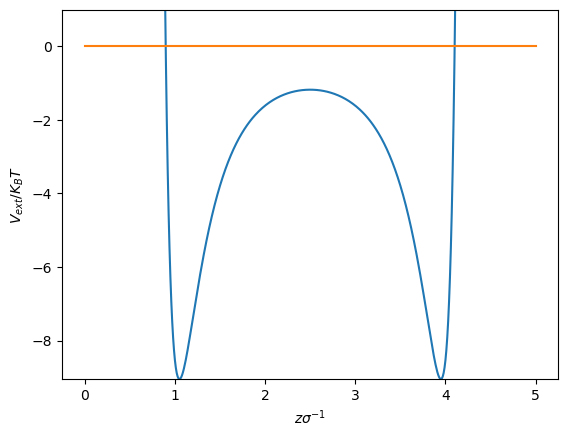

In [ ]:
#%%
#Temperature of the system [K]
T = 87.
#Volumar Pressure [Bar]
P = np.linspace(0.001,0.1,100)
#LJ Properties of the molecule probe
Sigma_ff = 3.305 #A
Sigma_ori=Sigma_ff
d_HS = 3.38#Sigma_ff
Eps_kb = 118.05 #K
#LJ Properties of the wall
E_eff = 17.61
Sigma_sf = 3.494
#Boltzmann constant
kb = 1.3806488e-23
#%%

#---------------------------------------------------------------------
#Nondimensionalization
#---------------------------------------------------------------------
# T[K] / Eps_kb[K]
T = T/Eps_kb

# bar -> Pa (kg/m s^2)
# kb [kg⋅m2⋅s−2/K] * Eps_kb[K] * Sigma_ff*1.e-10)**3 [m^3] ~ [kg/m s^2]
P = ((P*1.e5)/(kb*Eps_kb)*(Sigma_ff*1.e-10)**3)

# E_eff[K/A^2] / Eps_kb[K] * Sigma_ff^2 [A^2]
E_eff = E_eff#/Eps_kb*(Sigma_ff*Sigma_ff)

# Eps_kb[K]
Eps_kb = Eps_kb/Eps_kb

#d_HS[A] / Sigma_ff[A]
d_HS = d_HS/Sigma_ff

#Sigma_sf[A]/Sigma_ff[A]
Sigma_sf = Sigma_sf/Sigma_ff

#Sigma_ff[A]
Sigma_ff = Sigma_ff/Sigma_ff
#R_cut
rc_MF = 5.*Sigma_ff

#---------------------------------------------------------------------
#Building the simulation box
#---------------------------------------------------------------------
#Number of points of the grid
Nump = 501
#Step size on z direction
dz  = 0.01
#Tamanho
H = dz*(Nump-1)
#Spacial vector
Z_vec = np.linspace(0,H,Nump)

#---------------------------------------------------------------------
#Calculating bulk density (rho_H)

def Fobj_Rho(rho0):
    #Initial guess
    Eta = np.pi*rho0*Sigma_ff**3/6.
    #Carnahan–Starling equation of state
    P_cs = T*rho0*(1+Eta+Eta**2-Eta**3)/(1-Eta)**3
    #Mean-Field
    P_MF_WCA = rho0**2*0.5*(-np.sqrt(2)*(32./9.)*np.pi*Eps_kb*Sigma_ff**3 +
              (16./3.)*np.pi*Eps_kb*Sigma_ff**3*((Sigma_ff/(rc_MF))**3 -
              (1./3.)*(Sigma_ff/(5.*rc_MF))**9))
    P_c = P_cs+P_MF_WCA
    return (P_c-P_in)**2

rho_H = np.zeros(len(P))
for i in range(len(P)):
    P_in = P[i]
    minval = minimize(Fobj_Rho, 1.e-7, method='BFGS')
    rho_H[i] = minval.x

#---------------------------------------------------------------------
#Chemical-Potential calculation
#---------------------------------------------------------------------

#Ideal-Gas contribution
mu_ID = T*np.log(rho_H)

#Hard-Sphere contribution
EtaH = np.pi*rho_H*Sigma_ff**3/6.0
mu_HS = T*(EtaH*(8.0-9.0*EtaH+3.*EtaH**2)/(1.-EtaH)**3)

#Dispersive contribution
mu_MF_WCA = rho_H*(-np.sqrt(2)*(32./9.)*np.pi*Eps_kb*Sigma_ff**3 +
          (16./3.)*np.pi*Eps_kb*Sigma_ff**3*((Sigma_ff/(5.*Sigma_ff))**3 -
          (1./3.)*(Sigma_ff/(5.*Sigma_ff))**9))


mu_H = mu_ID+mu_HS+mu_MF_WCA

#---------------------------------------------------------------------
#External Potential
#---------------------------------------------------------------------

def Phi_ext(E_eff,Sigma_sf,dist):
    delta = 3.35/Sigma_ori
    if dist != 0:
        return E_eff*(0.4*(Sigma_sf/dist)**10-(Sigma_sf/dist)**4-(Sigma_sf**4/(3.*delta*(0.61*delta+dist)**3)))
    elif dist == 0:
        return 1e200

Vext_vec = np.zeros(Nump)

for i in range(Nump):
    Vext_vec[i] = T*Phi_ext(E_eff,Sigma_sf,Z_vec[i]) + \
                  T*Phi_ext(E_eff,Sigma_sf,H-Z_vec[i])

plt.plot(Z_vec,Vext_vec)
plt.plot(Z_vec,np.zeros((Nump)))
plt.ylabel("$V_{ext}/K_BT$")
plt.xlabel("$z \sigma^{-1}$")
plt.ylim(np.min(Vext_vec),1)
plt.show()

### Both FMT and MFA have a matrix of weights that will be used in all iterations. To reduce the computational cost, these matrices can be pre-calculated so that these kernels are used during the loop of the DFT solution method.

In [ ]:
#---------------------------------------------------------------------
#Calculation of the FMT weighting functions and Phi_WCA (Mods)
#---------------------------------------------------------------------
omega_weight = fmt.omega_calc(H, Nump, Sigma_ff, Z_vec)
MFA_weight = wca.MF_weight(Z_vec,rc_MF,Eps_kb,Sigma_ff)
#---------------------------------------------------------------------

AttributeError: module 'FMT_mod' has no attribute 'omega_calc'

### Now that everything is ready, we can start the Picard method for each point on the adsorption isotherm. One of the ways to obtain this curve is to make an initial guess of a constant density equal to the bulk density at the first point and use the previous profiles as an initial estimate of the next:

In [ ]:
Nads = np.zeros(len(P))

#Initial guess
rho_vec = np.zeros((Nump))+rho_H[0]
rho_vec_new = np.zeros((Nump))


for i in range(len(P)):
    #accuses the convergence of the method
    accu = 1

    #Tolerance
    tol = 1.e-7

    #mixing parameter
    alpha = 0.0009

    #tracking the iterations
    itera = 0

    while accu == 1:
        itera += 1
        dFhs = fmt.calc_dFHS(H, omega_weight, rho_vec, Nump, dz, T, d_HS, Z_vec)
        dFatt = wca.calc_dFAtt(H,MFA_weight,rho_vec,Nump,dz,Sigma_ff,
                               Eps_kb,Z_vec,rc_MF)
        rho_vec_new = np.exp(mu_H[i]/T-Vext_vec/T-dFhs/T-dFatt/T)

        err = sum((rho_vec_new-rho_vec)**2)/(Nump)
        if (err<tol):
            accu = 0
        rho_vec = (1.-alpha)*rho_vec+alpha*rho_vec_new
        #print(err)
        if err<0.01:
            alpha = 0.02
    Nads[i] = integrate.trapz(rho_vec,Z_vec)/(H-Sigma_sf)
    print(i,P[i],rho_H[i],Nads[i])
    #rho_H_vec = np.zeros((Nump))+rho_H[i]
    plt.plot(Z_vec,rho_vec,label="P ="+str(P[i]))
    #plt.plot(Z_vec,rho_H_vec)
plt.ylabel(r"$\rho \sigma^3$")
plt.xlabel("$z \sigma^{-1}$")
plt.show()

NameError: name 'omega_weight' is not defined

### Below is an example for the evaluation of the desorption isotherm for argon on graphite:
### Here we simply need to change the order in which $\mu_H$ is fed into the algorithm.

In [ ]:
Ndes = np.zeros(len(P))

for i in range(len(P)):
    #accuses the convergence of the method
    accu = 1

    #Tolerance
    tol = 1.e-7

    #mixing parameter
    alpha = 0.0009

    #tracking the iterations
    itera = 0

    while accu == 1:
        itera += 1
        dFhs = fmt.calc_dFHS(H, omega_weight, rho_vec, Nump, dz, T, d_HS, Z_vec)
        dFatt = wca.calc_dFAtt(H,MFA_weight,rho_vec,Nump,dz,Sigma_ff,
                               Eps_kb,Z_vec,rc_MF)
        rho_vec_new = np.exp(mu_H[len(P)-i-1]/T-Vext_vec/T-dFhs/T-dFatt/T)

        err = sum((rho_vec_new-rho_vec)**2)/(Nump)
        if (err<tol):
            accu = 0
        rho_vec = (1.-alpha)*rho_vec+alpha*rho_vec_new
        #print(err)
        if err<0.01:
            alpha = 0.02
    Ndes[i] = integrate.trapz(rho_vec,Z_vec)/(H-Sigma_sf)
    print(i,P[i],rho_H[i],Ndes[i])
    #rho_H_vec = np.zeros((Nump))+rho_H[i]
    plt.plot(Z_vec,rho_vec,label="P ="+str(P[i]))
    #plt.plot(Z_vec,rho_H_vec)
plt.ylabel(r"$\rho \sigma^3$")
plt.xlabel("$z \sigma^{-1}$")
plt.show()

NameError: name 'omega_weight' is not defined